In [25]:
import numpy as np
import pandas as pd
import regex as re
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import matplotlib.pyplot as plt
from math import sqrt

In [26]:
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
#load data
df = pd.read_csv('popuSingleVarNEW.csv')
data = df.copy()

In [28]:
data = data.drop(['Year'], axis=1)

In [29]:
data = data.rename(columns={'PopA60':'Pop'})

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Pop     43 non-null     int64
dtypes: int64(1)
memory usage: 476.0 bytes


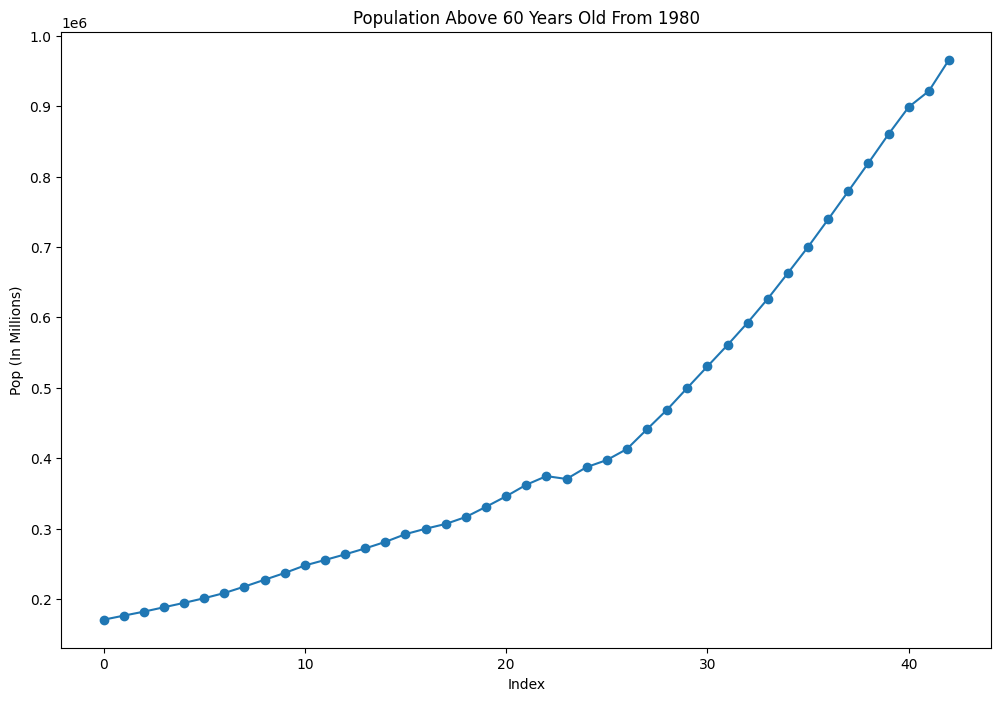

In [31]:
# Plot the data using the sequence index as the x-axis
plt.figure(figsize=(12,8))
plt.plot(data.index, data['Pop'], marker='o')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('Pop (In Millions)')
plt.title('Population Above 60 Years Old From 1980')

# Show the plot
plt.show()

## Data Preprocessing

In [32]:
# Create lag features
lags = 6 # can be adjusted
for i in range(1, lags + 1):
    data[f'lag_{i}'] = data.Pop.shift(i)


In [33]:
data

,Pop,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,170382,NaN,NaN,NaN,NaN,NaN,NaN
1,176170,170382.0,NaN,NaN,NaN,NaN,NaN
2,181822,176170.0,170382.0,NaN,NaN,NaN,NaN
3,188090,181822.0,176170.0,170382.0,NaN,NaN,NaN
4,194340,188090.0,181822.0,176170.0,170382.0,NaN,NaN
5,200954,194340.0,188090.0,181822.0,176170.0,170382.0,NaN
6,208304,200954.0,194340.0,188090.0,181822.0,176170.0,170382.0
7,217472,208304.0,200954.0,194340.0,188090.0,181822.0,176170.0
8,227175,217472.0,208304.0,200954.0,194340.0,188090.0,181822.0
9,236783,227175.0,217472.0,208304.0,200954.0,194340.0,188090.0


In [34]:
#Removes the rows based on the number of lags
data=data.iloc[lags:]

In [35]:
data

,Pop,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
6,208304,200954.0,194340.0,188090.0,181822.0,176170.0,170382.0
7,217472,208304.0,200954.0,194340.0,188090.0,181822.0,176170.0
8,227175,217472.0,208304.0,200954.0,194340.0,188090.0,181822.0
9,236783,227175.0,217472.0,208304.0,200954.0,194340.0,188090.0
10,247471,236783.0,227175.0,217472.0,208304.0,200954.0,194340.0
11,255255,247471.0,236783.0,227175.0,217472.0,208304.0,200954.0
12,263249,255255.0,247471.0,236783.0,227175.0,217472.0,208304.0
13,271741,263249.0,255255.0,247471.0,236783.0,227175.0,217472.0
14,281003,271741.0,263249.0,255255.0,247471.0,236783.0,227175.0
15,291997,281003.0,271741.0,263249.0,255255.0,247471.0,236783.0


In [36]:
#Resets index to 0
data.reset_index(drop=True,inplace=True)

In [37]:
data

,Pop,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,208304,200954.0,194340.0,188090.0,181822.0,176170.0,170382.0
1,217472,208304.0,200954.0,194340.0,188090.0,181822.0,176170.0
2,227175,217472.0,208304.0,200954.0,194340.0,188090.0,181822.0
3,236783,227175.0,217472.0,208304.0,200954.0,194340.0,188090.0
4,247471,236783.0,227175.0,217472.0,208304.0,200954.0,194340.0
5,255255,247471.0,236783.0,227175.0,217472.0,208304.0,200954.0
6,263249,255255.0,247471.0,236783.0,227175.0,217472.0,208304.0
7,271741,263249.0,255255.0,247471.0,236783.0,227175.0,217472.0
8,281003,271741.0,263249.0,255255.0,247471.0,236783.0,227175.0
9,291997,281003.0,271741.0,263249.0,255255.0,247471.0,236783.0


In [38]:
#Only takes the columns from the 36th column onwards
forecast_init = data.iloc[36:]
#Removes the "Pop row".
X_forecast_init = forecast_init.shift(periods=1,axis='columns').drop(['Pop'],axis=1)
X_forecast_init

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
36,966140,921620.0,898994.0,860508.0,819542.0,779343.0


In [39]:
# Split data into features (X) and target (y)
X = data.drop(['Pop'], axis=1)
y = data['Pop']

# Split data into training and testing/validation sets. Shuffle is set to False because this data is a time-series.
# Test size can be adjusted based on how much of the dataset you want to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) 

In [40]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,200954.0,194340.0,188090.0,181822.0,176170.0,170382.0
1,208304.0,200954.0,194340.0,188090.0,181822.0,176170.0
2,217472.0,208304.0,200954.0,194340.0,188090.0,181822.0
3,227175.0,217472.0,208304.0,200954.0,194340.0,188090.0
4,236783.0,227175.0,217472.0,208304.0,200954.0,194340.0
5,247471.0,236783.0,227175.0,217472.0,208304.0,200954.0
6,255255.0,247471.0,236783.0,227175.0,217472.0,208304.0
7,263249.0,255255.0,247471.0,236783.0,227175.0,217472.0
8,271741.0,263249.0,255255.0,247471.0,236783.0,227175.0
9,281003.0,271741.0,263249.0,255255.0,247471.0,236783.0


In [20]:
X_test

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
33,819542.0,779343.0,739423.0,700208.0,663103.0,626591.0
34,860508.0,819542.0,779343.0,739423.0,700208.0,663103.0
35,898994.0,860508.0,819542.0,779343.0,739423.0,700208.0
36,921620.0,898994.0,860508.0,819542.0,779343.0,739423.0


## Model Training 

In [41]:
# Define the parameter grid for hyperparameter tuning
# note: you can get the list of available parameters with `estimator_name.get_params().keys()` 
#       for example is the estimator_name = pipeline then run pipeline.get_params().keys() .

param_grid = { #this check for the best parameters. You can add more parameters and tune them.
    'regressor__max_iter':[500,1000,5000,15000],
    'regressor__alpha': [1, 10, 100],
    #'regressor__l1_ratio':[0.0, 0.05, 0.1, 0.3,0.5, 0.7, 0.9, 0.95, 1.0],
    #'regressor__eta0': [0.005,0.01,0.02,0.1],
    #'regressor__early_stopping':[True,False]
}

# Create a pipeline with StandardScaler and ElasticNet regressor
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', Ridge())
])

# Define time-aware cross-validation strategy
tscv = TimeSeriesSplit(n_splits=3)

# Define multiple scoring metrics
scoring = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'neg_mean_absolute_error': 'neg_mean_absolute_error',
    'neg_mean_absolute_percentage_error':'neg_mean_absolute_percentage_error', 
}

# Create a GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid, scoring= scoring, cv=tscv,refit='neg_root_mean_squared_error')

# Train the model with hyperparameter tuning
grid_search.fit(X_train, y_train)
#pipeline.fit(X_train,y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", grid_search.best_score_)

Best Parameters: {'regressor__alpha': 1, 'regressor__max_iter': 500}
Best RMSE: -15531.71501624294


In [23]:
# Convert the random search results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Define renaming patterns and replacements
renaming_patterns = [
    (r'_neg_root_mean_squared_error$', '_RMSE'),  
    (r'_neg_mean_absolute_error$', '_MAE'),  
    (r'_neg_mean_absolute_percentage_error$', '_MAPE'),  
    (r'^param_regressor__', '')  
]

# Rename columns using patterns and replacements
for pattern, replacement in renaming_patterns:
    results_df.columns = [re.sub(pattern, replacement, col) for col in results_df.columns]

# drop columns that we don't need
cols_to_drop = ['mean_fit_time','std_fit_time','mean_score_time','std_score_time']
results_df.drop(cols_to_drop,axis=1,inplace=True)

# Display result
results_df.sort_values(by=['rank_test_RMSE'])

,alpha,max_iter,params,split0_test_RMSE,split1_test_RMSE,split2_test_RMSE,mean_test_RMSE,std_test_RMSE,rank_test_RMSE,split0_test_MAE,...,split2_test_MAE,mean_test_MAE,std_test_MAE,rank_test_MAE,split0_test_MAPE,split1_test_MAPE,split2_test_MAPE,mean_test_MAPE,std_test_MAPE,rank_test_MAPE
0,1,500,"{'regressor__alpha': 1, 'regressor__max_iter':...",-5458.951159,-21594.203386,-19541.990504,-15531.715016,7171.625721,1,-4439.808078,...,-19375.791761,-13746.914240,6629.123954,1,-0.012950,-0.037301,-0.029157,-0.026469,0.010121,1
1,1,1000,"{'regressor__alpha': 1, 'regressor__max_iter':...",-5458.951159,-21594.203386,-19541.990504,-15531.715016,7171.625721,1,-4439.808078,...,-19375.791761,-13746.914240,6629.123954,1,-0.012950,-0.037301,-0.029157,-0.026469,0.010121,1
2,1,5000,"{'regressor__alpha': 1, 'regressor__max_iter':...",-5458.951159,-21594.203386,-19541.990504,-15531.715016,7171.625721,1,-4439.808078,...,-19375.791761,-13746.914240,6629.123954,1,-0.012950,-0.037301,-0.029157,-0.026469,0.010121,1
3,1,15000,"{'regressor__alpha': 1, 'regressor__max_iter':...",-5458.951159,-21594.203386,-19541.990504,-15531.715016,7171.625721,1,-4439.808078,...,-19375.791761,-13746.914240,6629.123954,1,-0.012950,-0.037301,-0.029157,-0.026469,0.010121,1
4,10,500,"{'regressor__alpha': 10, 'regressor__max_iter'...",-15214.055216,-31392.681992,-44904.666390,-30503.801199,12137.426409,5,-12731.508638,...,-44846.038641,-26594.820733,13472.838043,5,-0.036997,-0.045590,-0.066060,-0.049549,0.012191,5
5,10,1000,"{'regressor__alpha': 10, 'regressor__max_iter'...",-15214.055216,-31392.681992,-44904.666390,-30503.801199,12137.426409,5,-12731.508638,...,-44846.038641,-26594.820733,13472.838043,5,-0.036997,-0.045590,-0.066060,-0.049549,0.012191,5
6,10,5000,"{'regressor__alpha': 10, 'regressor__max_iter'...",-15214.055216,-31392.681992,-44904.666390,-30503.801199,12137.426409,5,-12731.508638,...,-44846.038641,-26594.820733,13472.838043,5,-0.036997,-0.045590,-0.066060,-0.049549,0.012191,5
7,10,15000,"{'regressor__alpha': 10, 'regressor__max_iter'...",-15214.055216,-31392.681992,-44904.666390,-30503.801199,12137.426409,5,-12731.508638,...,-44846.038641,-26594.820733,13472.838043,5,-0.036997,-0.045590,-0.066060,-0.049549,0.012191,5
8,100,500,"{'regressor__alpha': 100, 'regressor__max_iter...",-57410.676678,-88407.621240,-159445.210411,-101754.502776,42711.169137,9,-53876.239594,...,-156172.507592,-96851.109766,43332.346166,9,-0.160121,-0.176385,-0.225574,-0.187360,0.027825,9
9,100,1000,"{'regressor__alpha': 100, 'regressor__max_iter...",-57410.676678,-88407.621240,-159445.210411,-101754.502776,42711.169137,9,-53876.239594,...,-156172.507592,-96851.109766,43332.346166,9,-0.160121,-0.176385,-0.225574,-0.187360,0.027825,9


## Model Evaluation & Tuning

In [25]:
# Get the best estimator from the grid search
best_estimator = grid_search.best_estimator_

# Make predictions
predictions = best_estimator.predict(X_test)
#predictions = pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 34541.97902100233


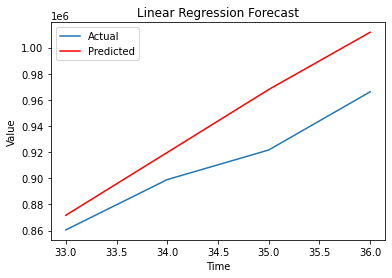

In [26]:
# Visualize the results
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Linear Regression Forecast')
plt.show()

In [27]:
best_estimator

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=1, max_iter=500))])

In [28]:
# Get the trained SGDRegressor from the best pipeline
sgd_regressor = best_estimator.named_steps['regressor']

# Get the StandardScaler from the pipeline
scaler = best_estimator.named_steps['scaler']

# Get the coefficients of the trained SGDRegressor
scaled_coefficients = sgd_regressor.coef_

# Get the scaling factors of the scaler
scaling_factors = scaler.scale_

# Calculate the original coefficients before scaling
original_coefficients = scaled_coefficients / scaling_factors

print("Scaled Coefficients:", scaled_coefficients)
print("Original Coefficients (Before Scaling):", original_coefficients)

Scaled Coefficients: [45097.48842384 37365.31133564 29623.61125907 22919.25140701
 19549.57610039 18307.56679832]
Original Coefficients (Before Scaling): [0.27705239 0.24578791 0.20886265 0.17322096 0.15837946 0.15875379]


## Prediction

In [30]:
forecast_init = data.iloc[36:]
X_forecast_init = forecast_init.shift(periods=1,axis='columns').drop(['Pop'],axis=1)
X_test1 = X_forecast_init.iloc[0:].to_numpy().flatten()
X_test1

array([966140., 921620., 898994., 860508., 819542., 779343.])

In [31]:
# Initialize variables
forecasted_values = []

# Number of future time steps to forecast
forecast_steps = 8

In [32]:
# Iterative one-step forecasting
for step in range(forecast_steps):
    # Make a one-step forecast using the model and current feature matrix
    forecast = best_estimator.predict(np.array([X_test1]))  # Reshape for prediction
    
    # Append the forecasted value to the list
    forecasted_values.append(forecast)
    
    # Update the feature matrix for the next time step (use the forecasted value)
    X_test1 = np.roll(X_test1, -1)  # Shift values to the left
    X_test1[-1] = forecast

# Convert the list of forecasted values to a numpy array
forecasted_values = np.array(forecasted_values).flatten()

print("Iterative Forecasted Values:", forecasted_values)


Iterative Forecasted Values: [1057424.23188778 1062173.95925988 1075722.79400053 1097667.82460964
 1140970.91697356 1211871.84679217 1314827.63821343 1359132.07482592]


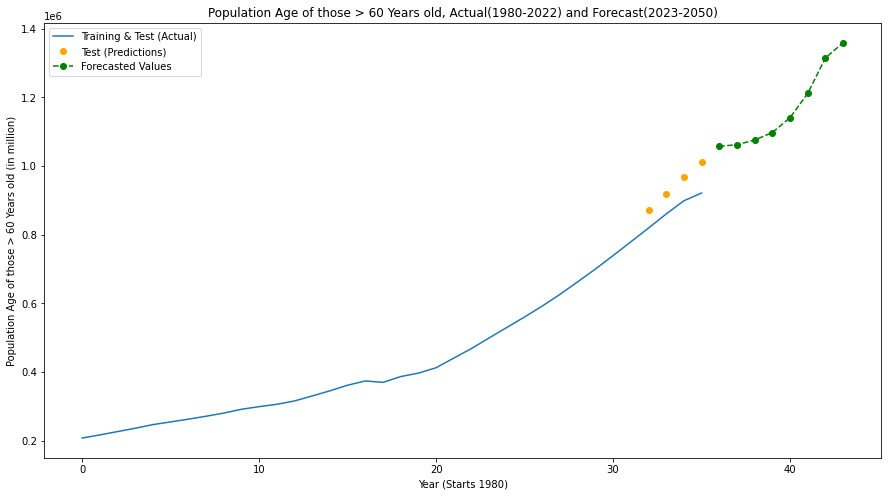

In [33]:
# Plotting
plt.figure(figsize=(15, 8))
plt.plot(y[:36], label='Training & Test (Actual)')
plt.plot(range(32, 36), predictions[0:4], label='Test (Predictions)', marker='o', linestyle='None', color='orange')
plt.plot(range(36, 44), forecasted_values, label='Forecasted Values', marker='o', linestyle='dashed', color='green')
plt.xlabel('Year (Starts 1980)')
plt.ylabel('Population Age of those > 60 Years old (in million)')
plt.title('Population Age of those > 60 Years old, Actual(1980-2022) and Forecast(2023-2050)')
plt.legend()
plt.show()
